# Chi-squared Distribution ($k=1$)


## Theory
Given a standard random variable $X \sim \mathcal{N}(0,1)$ we would like to find the random variable $Y = X^2$.
The analytic solution is known: $Y$ follows a chi-squared distribution with $k=1$ degree of freedom.

Using polynomial chaos expansion (PCE), the problem can be solved using Galerkin projection.
Let $\{\phi_k \}_{k=0}^{n}$ be the monic orthogonal basis relative to the probability density of $X$, namely
$$
f_X(x) = \frac{1}{\sqrt{2 \pi}} \exp \left( - \frac{x^2}{2} \right).
$$
Then, the PCE of $X$ is given by
$$
X = \sum_{k=0}^n x_k \phi_k,
$$
with
$$
x_0 = 0, \quad x_1 = 1, \quad x_i = 0 \quad \forall i =2,\dots,n.
$$
To find the PCE coefficients $y_k$ for $Y = \sum_{k=}^n y_k \phi_k$, we apply Galerkin projection, which leads to
$$
y_m \langle \phi_m, \phi_m \rangle = \sum_{i=0}^n \sum_{j=0}^n x_i x_j \langle \phi_i \phi_j, \phi_m \rangle \quad \forall m = 0, \dots, n.
$$
Hence, knowing the scalars $\langle \phi_m, \phi_m \rangle$, and $\langle \phi_i \phi_j, \phi_m \rangle$, the PCE coefficients $y_k$ can be obtained immediately.
From the PCE coefficients we can get the moments and compare them to the closed-form expressions.

__Notice:__ A maximum degree of 2 suffices to get the *exact* solution with PCE.
In other words, increasing the maximum degree to values greater than 2 introduces nothing but computational overhead (and numerical errors, possibly).


## Practice
First, we create a orthogonal basis relative to $f_X(x)$ of degree at most $d=2$ (`deg` below).

Notice that we consider a total of `Nrec` recursion coefficients, and that we also add a quadrature rule by calling `OrthoPolyQ()`.

In [2]:
using PolyChaos
k = 1
deg, Nrec = 2, 20
opq = GaussOrthoPoly(deg;Nrec=Nrec);

What are the basis polynomials?

In [3]:
showbasis(opq; sym="ξ") # works for `op` too!

1
ξ
ξ^2 - 1.0


Note that the command `showbasis` is based on the more general `showpoly`:

In [4]:
showpoly(0:2:deg,opq)

1
x^2 - 1.0


Next, we define the PCE for $X$.

In [5]:
L = dim(opq)
mu, sig = 0., 1.
x = [ convert2affinePCE(mu,sig,opq); zeros(Float64,L-2) ]

3-element Array{Float64,1}:
 0.0
 1.0
 0.0

With the orthogonal basis and the quadrature at hand, we can compute the tensors `t2` and `t3` that store the entries $\langle \phi_m, \phi_m \rangle$, and $\langle \phi_i \phi_j, \phi_m \rangle$, respectively.

In [6]:
t2 = Tensor(2,opq);
t3 = Tensor(3,opq)

Tensor(3,   [1 ]  =  1.0
  [4 ]  =  1.0
  [7 ]  =  2.0
  [9 ]  =  2.0
  [15]  =  8.0, getfield(PolyChaos, Symbol("#getfun#41")){Int64,GaussOrthoPoly,SparseArrays.SparseVector{Float64,Int64}}(3, GaussOrthoPoly(2, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0], GaussMeasure(PolyChaos.w_gaussian, (-Inf, Inf), true), Quad("golubwelsch", 19, [-7.38258, -6.26289, -5.32054, -4.46587, -3.66442, -2.89805, -2.1555, -1.42888, -0.712085, -2.10166e-16, 0.712085, 1.42888, 2.1555, 2.89805, 3.66442, 4.46587, 5.32054, 6.26289, 7.38258], [7.48283e-13, 1.22037e-9, 2.53222e-7, 1.53511e-5, 0.000378502, 0.00450724, 0.0286667, 0.103604, 0.220942, 0.283773, 0.220942, 0.103604, 0.0286667, 0.00450724, 0.000378502, 1.53511e-5, 2.53222e-7, 1.22037e-9, 7.48283e-13])),   [1 ]  =  1.0
  [4 ]  =  1.0
  [7 ]  =  2.0
  [9 ]  =  2.0
  [15]  =  8.0), GaussOr

With the tensors at hand, we can compute the Galerkin projection.

In [7]:
y = [ sum( x[i]*x[j]*t3.get([i-1,j-1,m-1])/t2.get([m-1,m-1])  for i=1:L, j=1:L ) for m=1:L ]

3-element Array{Float64,1}:
 1.0               
 0.0               
 1.0000000000000033

Let's compare the moments via PCE to the closed-form expressions.

In [8]:
moms_analytic(k) = [k, sqrt(2k), sqrt(8/k)]
function myskew(y)
   e3 = sum( y[i]*y[j]*y[k]*t3.get([i-1,j-1,k-1]) for i=1:L,j=1:L,k=1:L )
   μ = y[1]
   σ = std(y,opq)
   (e3-3*μ*σ^2-μ^3)/(σ^3)
end

print("Expected value:\t\t$(moms_analytic(k)[1]) = $(mean(y,opq))\n")
print("\t\t\terror = $(abs(mean(y,opq)-moms_analytic(k)[1]))\n")
print("Standard deviation:\t$(moms_analytic(k)[2]) = $(std(y,opq))\n")
print("\t\t\terror = $(moms_analytic(k)[2]-std(y,opq))\n")
print("Skewness:\t\t$(moms_analytic(k)[3]) = $(myskew(y))\n")
print("\t\t\terror = $(moms_analytic(k)[3]-myskew(y))\n")


Expected value:		1.0 = 1.0
			error = 0.0
Standard deviation:	1.4142135623730951 = 1.4142135623730998
			error = -4.6629367034256575e-15
Skewness:		2.8284271247461903 = 2.8284271247462023
			error = -1.199040866595169e-14


Let's plot the probability density function to compare results.
We first draw samples from the measure with the help of `sampleMeasure()`, and then evaluate the basis at these samples and multiply times the PCE coefficients.
The latter stop is done using `evaluatePCE()`.
Finally, we compare the result against the analytical PDF $\rho(t) = \frac{\mathrm{e}^{-0.5t}}{\sqrt{2 t} \, \Gamma(0.5)}$ of the chi-squared distribution with one degree of freedom.

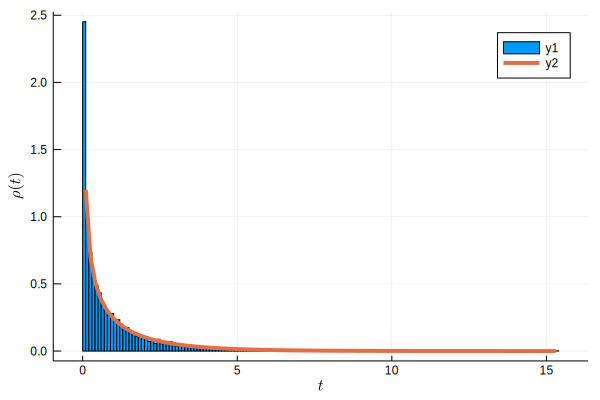

In [10]:
using Plots, LaTeXStrings
gr()
Nsmpl = 10000
#ξ = sampleMeasure(Nsmpl,opq)
#ysmpl = evaluatePCE(y,ξ,opq)
ysmpl = samplePCE(Nsmpl,y,opq)
histogram(ysmpl;normalize=true,xlabel=L"t",ylabel=L"\rho(t)")


import SpecialFunctions: gamma
ρ(t) = 1/(sqrt(2)*gamma(0.5))*1/sqrt(t)*exp(-0.5*t)
t = range(0.1; stop=maximum(ysmpl), length=100)
plot!(t,ρ.(t),w=4)